In [1]:
from etcpy import etc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import GEMS
import os
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import ttest_ind as ttest
from sklearn.decomposition import PCA
from scipy import stats 
from matplotlib import gridspec
from statsmodels.stats.multitest import multipletests

In [2]:
model = pickle.load(open('../results/smcabc_gem_three_conditions_save_all_particles.pkl','rb'))

In [3]:
def load_param_mean_std(population):
    # return a datafram with Tm, Topt, dCpt as columns
    params_lst = {idd:[p[idd] for p in population] for idd in population[0].keys()}
    df = pd.DataFrame()
    
    for idd,lst in params_lst.items():
        [prot,param] = idd.split('_')
        if param in ['Tm','Topt']:
            df.loc[prot,'{0}_mean'.format(param)] = np.mean(lst) - 273.15 # C
            df.loc[prot,'{0}_std'.format(param)] = np.std(lst)
        if param in ['dCpt']:
            df.loc[prot,'{0}_mean'.format(param)] = np.mean(lst)/1000 # kJ/mol/K
            df.loc[prot,'{0}_std'.format(param)] = np.std(lst)/1000
    return df

In [4]:
dfpost = load_param_mean_std(model.population)

In [5]:
# update params with posterior params mean
post_params = GEMS.params.copy()
for enz in post_params.index:
    post_params.loc[enz,'Topt'] = dfpost.loc[enz,'Topt_mean'] + 273.15
    post_params.loc[enz,'Tm']   = dfpost.loc[enz,'Tm_mean'] + 273.15
    post_params.loc[enz,'dCpt'] = dfpost.loc[enz,'dCpt_mean']*1000
    
    if ~np.isnan(post_params.loc[enz,'T90']):
        dT = GEMS.params.loc[enz,'T90']-GEMS.params.loc[enz,'Tm']
        post_params.loc[enz,'T90']   = post_params.loc[enz,'Tm'] + dT

In [6]:
dftherm = etc.calculate_thermal_params(post_params)

In [8]:
Ts = np.arange(0,64) 
fNTs = list()
sort_enzymes_on_Tm = dftherm.index[np.argsort(post_params['Tm'].values)]
for enz in sort_enzymes_on_Tm:
    cols = ['dHTH', 'dSTS','dCpu','Topt']
    [dHTH, dSTS,dCpu,topt]=dftherm.loc[enz,cols]
    fNT = etc.get_fNT(Ts + 273.15,dHTH,dSTS,dCpu)
    fNTs.append(fNT)

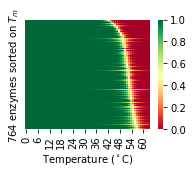

In [9]:
plt.figure(figsize=(2.8,2.4))
sns.heatmap(fNTs,cmap='RdYlGn')
plt.xlabel('Temperature ($^\circ$C)')
plt.yticks([])
plt.ylabel('{0} enzymes sorted on $T_m$'.format(len(dftherm.index)))
plt.tight_layout()
plt.savefig('../figures/denature_heatmap.png',bbox_inches='tight',dpi=300)
plt.show()

In [13]:
x = np.array(fNTs)
x[x[:,42]<0.1].shape

(2, 64)

In [17]:
post_params.loc[sort_enzymes_on_Tm[:10],:]-273.15

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std
P32476,24.000894,-260.15,222.85,36.794409,-269.75,38.536753,-6718.621378,1726.85
P07251,21.510471,-260.15,271.85,37.493722,-269.75,52.798213,-6850.768637,1726.85
P40825,24.765075,-260.15,709.85,40.631868,-269.75,42.344720,-8006.768057,1726.85
P15180,22.684211,-260.15,317.85,40.871440,-269.75,42.829016,-6558.818220,1726.85
P33330,27.566296,-260.15,121.85,41.125420,-269.75,43.509045,-8276.762143,1726.85
P09950,26.824595,-260.15,274.85,41.303210,-269.75,43.152580,-5479.138440,1726.85
P32473,25.716693,-260.15,92.85,41.400961,-269.75,43.111326,-5826.452630,1726.85
P00330,27.936976,-260.15,74.85,41.772523,-269.75,42.454660,-6945.707289,1726.85
P00937,25.676919,-260.15,210.85,41.832481,-269.75,43.830947,-6651.366260,1726.85
P00927,27.022559,-260.15,302.85,42.098618,-269.75,44.078826,-4877.915405,1726.85


In [10]:
Ts = np.arange(0,64) 
kcatTs = list()
sort_enzymes_on_Topt = dftherm.index[np.argsort(post_params['Topt'].values)]
for enz in sort_enzymes_on_Tm:
    cols = ['dHTH', 'dSTS','dCpu','Topt','dCpt']
    [dHTH, dSTS,dCpu,Topt,dCpt]=dftherm.loc[enz,cols]
    kcatT = etc.calculate_kcatT(Ts+273.15,dHTH,dSTS,dCpu,1,dCpt,Topt)
    kcatTs.append(kcatT)

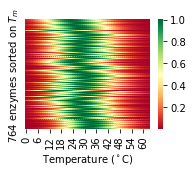

In [11]:
plt.figure(figsize=(2.8,2.4))
sns.heatmap(kcatTs,cmap='RdYlGn')
plt.xlabel('Temperature ($^\circ$C)')
plt.yticks([])
plt.ylabel('%s enzymes sorted on $T_{m}$' % len(dftherm.index))
plt.tight_layout()
plt.savefig('../figures/kcat_heatmap.png',bbox_inches='tight',dpi=300)
plt.show()

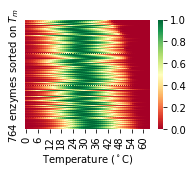

In [12]:
SAs = np.array(fNTs)*np.array(kcatTs)
plt.figure(figsize=(2.8,2.4))
sns.heatmap(SAs,cmap='RdYlGn')
plt.xlabel('Temperature ($^\circ$C)')
plt.yticks([])
plt.ylabel('%s enzymes sorted on $T_{m}$' % len(dftherm.index))
plt.tight_layout()
plt.savefig('../figures/Sa_heatmap.png',bbox_inches='tight',dpi=300)
plt.show()

In [19]:
dftherm.head()

,dHTH,dSTS,dCpu,Topt,dCpt
O13525,1.483000e+06,4893.450000,16132.124882,304.383942,-6303.243842
P00044,1.297372e+06,4263.848039,12354.234601,308.056808,-6780.270704
P00045,5.950000e+05,1947.510000,6636.120470,311.153254,-6073.135267
P00127,7.310000e+05,2398.690000,7677.937575,301.887468,-6887.987642
P00128,6.510000e+05,2133.290000,6579.105203,297.764072,-6560.470954


In [17]:
post_params.head()

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std
O13525,304.383942,13,335,324.285927,5.91247,NaN,-6303.243842,2000
P00044,308.056808,13,109,321.519662,3.40000,324.351882,-6780.270704,2000
P00045,311.153254,13,113,331.309673,5.91247,NaN,-6073.135267,2000
P00127,301.887468,13,147,326.611520,5.91247,NaN,-6887.987642,2000
P00128,297.764072,13,127,325.823369,5.91247,NaN,-6560.470954,2000


In [6]:
fNTs = dict()
kcatTs = dict()

In [13]:
np.isnan(GEMS.params.loc['O13525','T90'])

True

In [12]:
GEMS.params.loc['O13525','T90']

nan

In [8]:
GEMS.params.head()

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std
O13525,310.15,13,335,324.625351,5.91247,NaN,-6300,2000
P00044,314.15,13,109,321.817780,3.40000,324.65,-6300,2000
P00045,317.15,13,113,324.625351,5.91247,NaN,-6300,2000
P00127,317.15,13,147,324.625351,5.91247,NaN,-6300,2000
P00128,309.15,13,127,324.625351,5.91247,NaN,-6300,2000


In [9]:
dfpost.head()

,Tm_mean,Tm_std,Topt_mean,Topt_std,dCpt_mean,dCpt_std
O13525,51.135927,4.564094,31.233942,3.879392,-6.303244,1.802793
P00044,48.369662,5.158030,34.906808,3.241330,-6.780271,3.455483
P00045,58.159673,7.309203,38.003254,4.682154,-6.073135,1.239030
P00127,53.461520,4.411527,28.737468,7.838538,-6.887988,1.357107
P00128,52.673369,5.439958,24.614072,6.719203,-6.560471,1.568349
